In [1]:
import pandas as pd

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Descriptive Analysis

In [2]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path.home() / "Desktop" / "Sustainable-Aware-Exp"
hotels_path = BASE_DIR / "Hotels"/ "merged_all_hotels.csv"
hotels = pd.read_csv(hotels_path)
hotels['Domain'] = "Hotels"

backpacks_path = BASE_DIR / "Backpacks"/ "merged_all_backpacks.csv"
backpacks = pd.read_csv(backpacks_path)
backpacks['Domain'] = "Backpacks"


df = pd.concat([hotels, backpacks], ignore_index=True)

# 1. Map "Yes" to 1, "No" to 0
df['SustainableChoice_binary'] = df['SustainableChoice'].map({'Yes': 1, 'No': 0})

print(f"df → {df.shape[0]} rows, {df.shape[1]} columns")


# 2. Group by 'Group' and calculate the average
group_sum = df['Group'].value_counts()
print(group_sum)
print('-' * 50)

# 2. Group by 'Domain' and calculate the average
group_sum = df['Domain'].value_counts()
print(group_sum)
print('-' * 50)


# 2. Group by 'GenderIdentification' and calculate the average
group_sum = df['GenderIdentification'].value_counts()
print(group_sum)
print('-' * 50)


# 2. Group by 'Age' and calculate the average
group_sum = df['Age'].value_counts()
print(group_sum)
print('-' * 50)

# 2. Group by 'Domain' and calculate the Group
group_sum = df.groupby('Domain')['Group'].value_counts()
print(group_sum)
print('-' * 50)

# 2. Group by 'Domain' and calculate the GenderIdentification
group_sum = df.groupby('Domain')['GenderIdentification'].value_counts()
print(group_sum)
print('-' * 50)

# 2. Group by 'Domain' and calculate the Age
group_sum = df.groupby('Domain')['Age'].value_counts()
print(group_sum)
print('-' * 50)

df → 300 rows, 13 columns
Group
Salience               60
Framing                60
Simplification         60
Control                60
ExternalInformation    60
Name: count, dtype: int64
--------------------------------------------------
Domain
Hotels       150
Backpacks    150
Name: count, dtype: int64
--------------------------------------------------
GenderIdentification
Male      154
Female    144
Other       2
Name: count, dtype: int64
--------------------------------------------------
Age
25 – 34 years old    108
35 – 44 years old     72
45 – 54 years old     56
18 – 24 years old     29
55 – 64 years old     25
65 – 74 years old     10
Name: count, dtype: int64
--------------------------------------------------
Domain     Group              
Backpacks  Control                30
           ExternalInformation    30
           Framing                30
           Salience               30
           Simplification         30
Hotels     Control                30
           External

# RQ1:  Do differently nudged sustainable-aware explanations increase the likelihood of selecting the more sustainable item, and whether the effect remain consistent across the two item domains after controlling for age and gender?



## Percentage of sustainable choices for each domain Figure 1 in Paper

/var/folders/x5/4x0pvs_971l5vwmtfgh5snfr0000gn/T/ipykernel_6615/3398916920.py:94: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


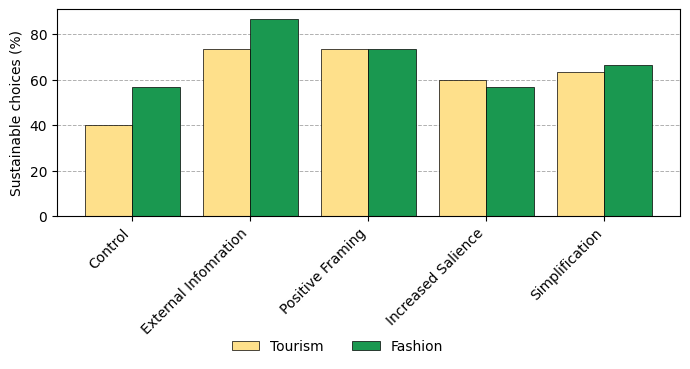

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1.  Compute the percentage of sustainable choices for each domain
# ------------------------------------------------------------------
domains = ["Hotels", "Backpacks"]
pct_by_domain = {
    d: (df[df["Domain"] == d]
        .groupby("Group")["SustainableChoice_binary"]
        .mean()
        .mul(100)
        .sort_index())               
    for d in domains
}

groups_order = pct_by_domain["Hotels"].index       

# Assemble a single DataFrame for plotting
plot_df = pd.DataFrame({
    "Hotels"   : pct_by_domain["Hotels"].loc[groups_order],
    "Backpacks": pct_by_domain["Backpacks"].loc[groups_order]
})

# ------------------------------------------------------------------
# 2.  Define one colour per domain
# ------------------------------------------------------------------
domain_colors = {
    "Hotels"   : "#fee08b",  
    "Backpacks": "#1a9850"    
}

# ------------------------------------------------------------------
# 3.  Side-by-side bar plot
# ------------------------------------------------------------------
groups_order = plot_df.index.tolist()

# Define new labels you want to show instead:
new_labels = [
    'Control',
    "External Infomration",
    "Positive Framing",
    "Increased Salience",
    "Simplification",
]

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)
bar_width = 0.4
x = np.arange(len(groups_order))

ax.bar(x - bar_width/2, plot_df["Hotels"],    width=bar_width,
       color=domain_colors["Hotels"],   label="Tourism", edgecolor="black",
       linewidth=.5)


ax.bar(x + bar_width/2, plot_df["Backpacks"], width=bar_width,
       color=domain_colors["Backpacks"],label="Fashion", edgecolor="black",
       linewidth=.5)


ax.grid(which="major", axis="y", linestyle="--", linewidth=0.7)
ax.set_axisbelow(True)   # ensure bars are drawn on top of the grid
ax.set_ylabel("Sustainable choices (%)")
ax.set_xticks(x)
ax.set_xticklabels(new_labels, rotation=45, ha="right")

ax.legend(
    title=" \n\n\n",
    loc="upper center",
    bbox_to_anchor=(0.45, -0.2),  
    ncol=2,                        
    frameon=False                 
)

plt.tight_layout()
plt.show()



## Binary Logistic Regression

In [3]:
import statsmodels.formula.api as smf

df['SustainableChoice_binary'] = df['SustainableChoice'].map({'Yes':1,'No':0})
df['Domain'] = pd.Categorical(df['Domain'], categories=['Hotels','Backpacks'])

model = smf.logit(
    'SustainableChoice_binary ~ '
    'C(Group, Treatment(reference="Control")) + '
    'C(Domain, Treatment(reference="Hotels")) + '
    'C(Group, Treatment(reference="Control")):C(Domain, Treatment(reference="Hotels")) + '
    'C(GenderIdentification, Treatment(reference="Female")) + '
    'SpecificAge',
    data=df
).fit(disp=False)

print(model.summary())


                              Logit Regression Results                              
Dep. Variable:     SustainableChoice_binary   No. Observations:                  300
Model:                                Logit   Df Residuals:                      287
Method:                                 MLE   Df Model:                           12
Date:                      Tue, 22 Apr 2025   Pseudo R-squ.:                 0.05550
Time:                              11:33:05   Log-Likelihood:                -183.45
converged:                             True   LL-Null:                       -194.23
Covariance Type:                  nonrobust   LLR p-value:                   0.04273
                                                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# ------------------------------------------------------------------
# Binary Logistic Regression with Pairs as Random Effects
# ------------------------------------------------------------------

import statsmodels.formula.api as smf
import statsmodels.api as sm


df['SustainableChoice_binary'] = df['SustainableChoice'].map({'Yes':1,'No':0})
df['Domain'] = pd.Categorical(df['Domain'], categories=['Hotels','Backpacks'])

glm = smf.glm(
    'SustainableChoice_binary ~ '
    'C(Group, Treatment("Control")) + '
    'C(Domain, Treatment("Hotels")) + '
    'C(Group, Treatment("Control")):C(Domain, Treatment("Hotels")) + '
    'C(GenderIdentification, Treatment("Female")) + SpecificAge',
    data=df,
    family=sm.families.Binomial())

result = glm.fit(cov_type='cluster', cov_kwds={'groups': df['Pair']})
print(result.summary())


                    Generalized Linear Model Regression Results                     
Dep. Variable:     SustainableChoice_binary   No. Observations:                  300
Model:                                  GLM   Df Residuals:                      287
Model Family:                      Binomial   Df Model:                           12
Link Function:                        Logit   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -183.45
Date:                      Sun, 27 Apr 2025   Deviance:                       366.91
Time:                              23:07:16   Pearson chi2:                     299.
No. Iterations:                           4   Pseudo R-squ. (CS):            0.06935
Covariance Type:                    cluster                                         
                                                                                                        coef    std err          z      P>|z|      [0.

# RQ2: Among treatment groups, do participants who opt for the sustainable option (Yes-choosers) rate the explanations higher on the sustainability-focused dimensions than those who do not (No-choosers)?

##  Mann–Whitney Tests

In [30]:

import pandas as pd
from scipy.stats import shapiro, kruskal, mannwhitneyu
import itertools
from pathlib import Path
from itertools import product



BASE_DIR = Path.home() / "Desktop" / "Sustainable-Aware-Exp"
hotels_path = BASE_DIR / "Hotels"/ "merged_all_hotels_treatment.csv"
hotels = pd.read_csv(hotels_path)
hotels['Domain'] = "Hotels"

backpacks_path = BASE_DIR / "Backpacks"/ "merged_all_backpacks_treatment.csv"
backpacks = pd.read_csv(backpacks_path)
backpacks['Domain'] = "Backpacks"


df = pd.concat([hotels, backpacks], ignore_index=True)


cat_cols = [
    'SustainableChoice',
    'SustainabilityInclination/Influence',      #Sustainability Persuasiveness
    'SustainabilityAwareness/Effectiveness',    #Sustainability Effectiveness
    'SustainabilityImportance',                 #Sustainability Importance

]

# mapping for 5‑point Likert
likert_map = {
    'Strongly Disagree': 1,
    'Disagree'         : 2,
    'Neutral'          : 3,
    'Agree'            : 4,
    'Strongly Agree'   : 5
}

for col in cat_cols[1:]:
    code_col = f"{col}_code"
    df[code_col] = df[col].map(likert_map)
    
    # split into Yes/No choosers
    yes_scores = df.loc[df['SustainableChoice']=='Yes', code_col].dropna()
    no_scores  = df.loc[df['SustainableChoice']=='No',  code_col].dropna()
    
    # descriptive
    m_yes = yes_scores.mean() if len(yes_scores) else float('nan')
    m_no  = no_scores.mean()  if len(no_scores)  else float('nan')
    
    # --- Normality check: Shapiro–Wilk ---
    s_yes, p_yes = shapiro(yes_scores)
    s_no,  p_no  = shapiro(no_scores)


    # Mann–Whitney U (one‑tailed: Yes > No)
    u_stat, p_val = mannwhitneyu(yes_scores, no_scores, alternative='greater')
    
    print(f"\n--- {col} ---")
    print(f" n(Yes)={len(yes_scores)}, mean={m_yes:.2f}")
    print(f" n(No) ={len(no_scores)}, mean={m_no:.2f}")
    print(f" Shapiro Yes: W={s_yes:.3f}, p={p_yes:.3f}")
    print(f" Shapiro  No: W={s_no:.3f}, p={p_no:.3f}")
    print(f" Mann–Whitney U = {u_stat:.1f}, p‑value (Yes > No) = {p_val:.3f}")



--- SustainabilityInclination/Influence ---
 n(Yes)=166, mean=3.99
 n(No) =74, mean=3.22
 Shapiro Yes: W=0.799, p=0.000
 Shapiro  No: W=0.886, p=0.000
 Mann–Whitney U = 8463.0, p‑value (Yes > No) = 0.000

--- SustainabilityAwareness/Effectiveness ---
 n(Yes)=166, mean=4.04
 n(No) =74, mean=3.62
 Shapiro Yes: W=0.799, p=0.000
 Shapiro  No: W=0.889, p=0.000
 Mann–Whitney U = 7786.5, p‑value (Yes > No) = 0.000

--- SustainabilityImportance ---
 n(Yes)=166, mean=4.08
 n(No) =74, mean=3.68
 Shapiro Yes: W=0.821, p=0.000
 Shapiro  No: W=0.882, p=0.000
 Mann–Whitney U = 7630.0, p‑value (Yes > No) = 0.001
